c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


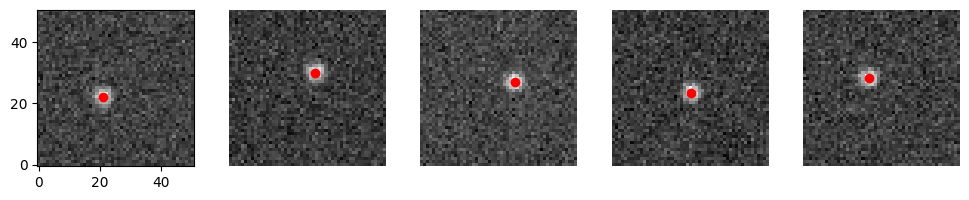

In [ ]:
#%% Import and define data

import deeptrack as dt
from numpy.random import uniform
import torch
import matplotlib.pyplot as plt
import deeplay as dl
from kornia.geometry.transform import translate
from kornia.geometry.transform import rotate
from torch import rand
import numpy as np

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

simulation = (optics(particle) >> dt.NormalizeMinMax()
              >> dt.Gaussian(sigma=0.1) >> dt.MoveAxis(-1, 0)
              >> dt.pytorch.ToTensor(dtype=torch.float32))

train_dataset = dt.pytorch.Dataset(simulation, length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    image, position = test_dataset[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# %% Neural network

backbone = dl.ConvolutionalNeuralNetwork(
    in_channels=1, hidden_channels=[16, 32, 64], out_channels=128,
    pool=torch.nn.MaxPool2d(2),
)
model = dl.Sequential(backbone, torch.nn.Flatten(), torch.nn.LazyLinear(2))
print(model)

def image_translation(batch, translation):
    """Translate a batch of images."""
    xy_flipped_translation = translation[:, [1, 0]]
    return translate(batch, xy_flipped_translation, padding_mode="reflection")

def inverse_translation(preds, applied_translation):
    """Invert translation of predicted positions."""
    return preds - applied_translation

class ParticleLocalizer(dl.Application):
    """LodeSTAR implementation with translations."""

    def __init__(self, model, n_transforms=8, **kwargs):
        """Initialize the ParticleLocalizer."""
        self.model, self.n_transforms = model, n_transforms
        super().__init__(**kwargs)

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)

    def random_arguments(self):
        """Generate random arguments for transformations."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5)}

    def forward_transform(self, batch, translation):
        """Apply forward translation to the image."""
        return image_translation(batch, translation)

    def inverse_transform(self, preds, translation):
        """Apply inverse translation to the predictions."""
        return inverse_translation(preds, translation)

    def training_step(self, image, batch_idx):
        """Perform a single training step."""
        image, *_ = image
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        pred_position = self(transformed_batch)
        pred_position = self.inverse_transform(pred_position, **kwargs)

        average_pred_position = pred_position \
            .mean(dim=0, keepdim=True).repeat(self.n_transforms, 1)
        loss = self.loss(pred_position, average_pred_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

localizer = ParticleLocalizer(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=5e-4),
).create()

dataloader = dl.DataLoader(train_dataset, batch_size=1, shuffle=True)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Layer[Conv2d](in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        (activation): Layer

In [ ]:
#%% Training

trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | trai

Training: |          | 0/? [00:00<?, ?it/s]

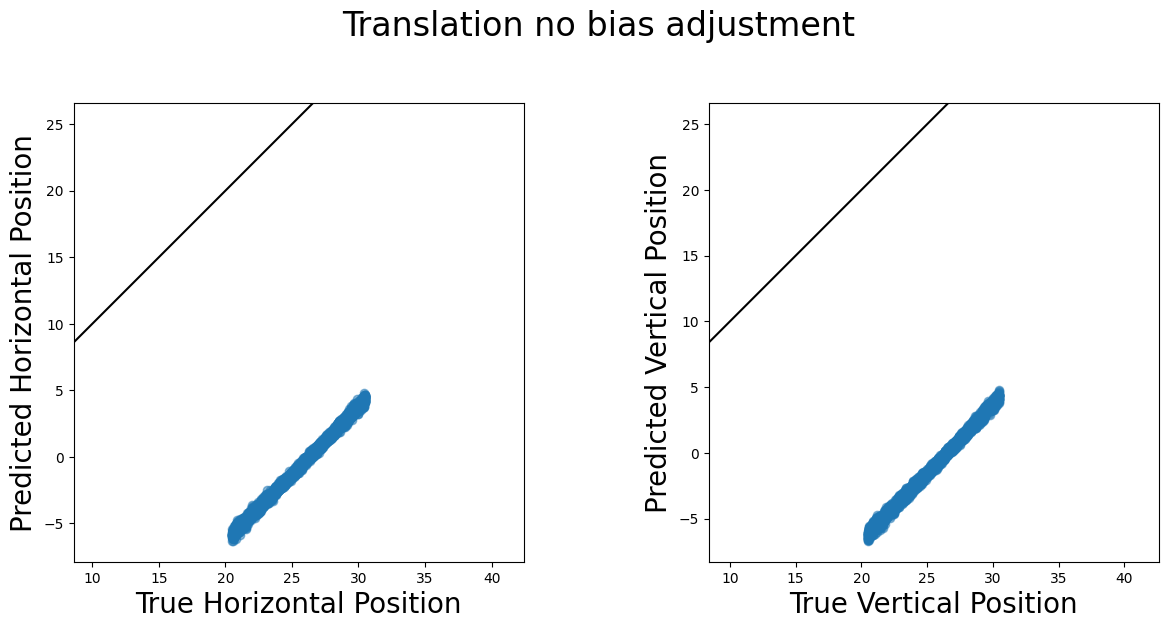

In [ ]:
#%% Evaluate

images, positions = zip(*test_dataset)
images, positions = torch.stack(images), torch.stack(positions)

predictions = localizer(images).detach().numpy()

def plot_position_comparison(positions, predictions, title = "Translation no bias adjustment"):
    """Plot comparison between predicted and real particle positions."""
    plt.figure(figsize=(14, 8))
    grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

    plt.subplot(grid[1:, :3])
    plt.scatter(positions[:, 0], predictions[:, 0], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Horizontal Position", fontsize=20)
    plt.ylabel("Predicted Horizontal Position", fontsize=20)
    plt.axis("equal")

    plt.subplot(grid[1:, 4:])
    plt.scatter(positions[:, 1], predictions[:, 1], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Vertical Position", fontsize=20)
    plt.ylabel("Predicted Vertical Position", fontsize=20)
    plt.axis("equal")

    plt.suptitle(title, fontsize = 24, y = 0.8)
    plt.show()

plot_position_comparison(positions, predictions)

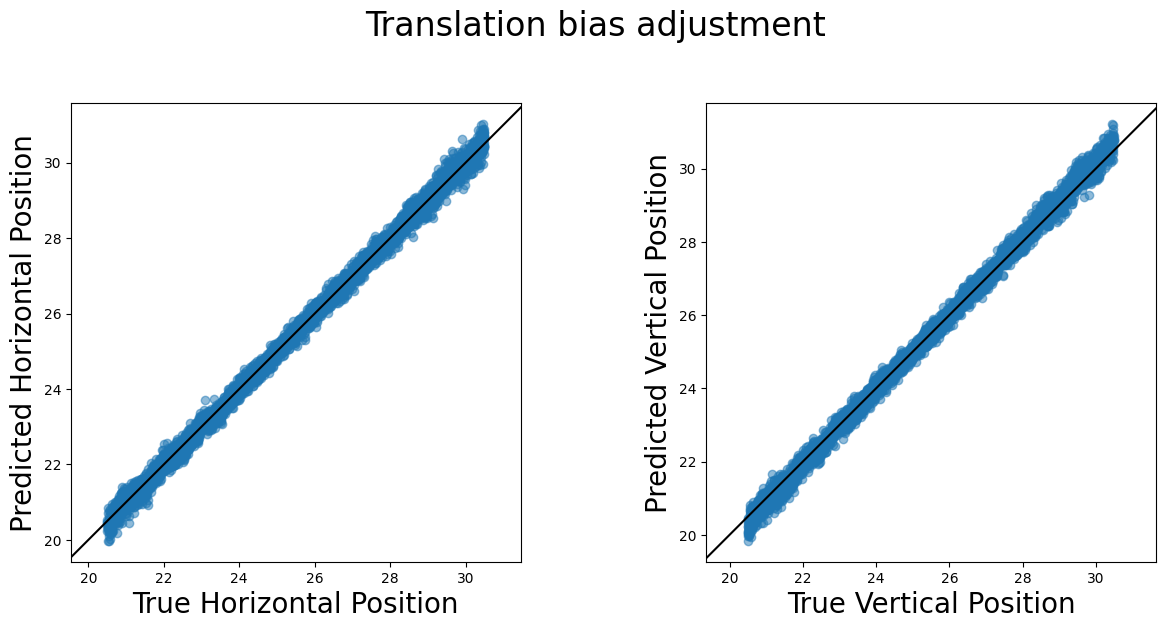

In [ ]:
#%% Improve predictions to bias

direct_preds = localizer(images).detach().numpy()

flipped_images = images.flip(dims=(2, 3))
flipped_preds = localizer(flipped_images).detach().numpy()

predictions_with_difference = ((direct_preds - flipped_preds) / 2
                               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions_with_difference, title="Translation bias adjustment")

In [ ]:
#%% Learn from flipping image

def flip_transform(batch, should_flip, dim):
    """Conditionally flip batch along a specified dimension."""
    should_flip = should_flip.view(-1, 1, 1, 1)
    return torch.where(should_flip, batch.flip(dims=(dim,)), batch)

def inverse_flip_transform(preds, should_flip, dim):
    """Conditionally inverse flip transformation based on should flip."""
    should_flip_mask = torch.zeros_like(preds).bool()
    should_flip_mask[should_flip, dim] = 1
    return torch.where(should_flip_mask, -preds, preds)

class ParticleLocalizerWithFlips(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""

    def forward_transform(self, batch, translation, flip_x, flip_y):
        """Apply forward translations and flips to the batch."""
        batch = image_translation(batch, translation)
        batch = flip_transform(batch, flip_x, dim=3)
        batch = flip_transform(batch, flip_y, dim=2)
        return batch

    def inverse_transform(self, preds, translation, flip_x, flip_y):
        """Apply the inverse transformation to the predictions."""
        preds = inverse_flip_transform(preds, flip_x, dim=1)
        preds = inverse_flip_transform(preds, flip_y, dim=0)
        preds = inverse_translation(preds, translation)
        return preds

    def random_arguments(self):
        """Generate random arguments for translations and flips."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "flip_x": rand(self.n_transforms).float().to(self.device) > 0.5,
            "flip_y": rand(self.n_transforms).float().to(self.device) > 0.5}

In [ ]:
#%% Training with flips

localizer_with_flips = ParticleLocalizerWithFlips(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3),
).create()
trainer_with_flips = dl.Trainer(max_epochs=100)
trainer_with_flips.fit(localizer_with_flips, dataloader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Para

Training: |          | 0/? [00:00<?, ?it/s]

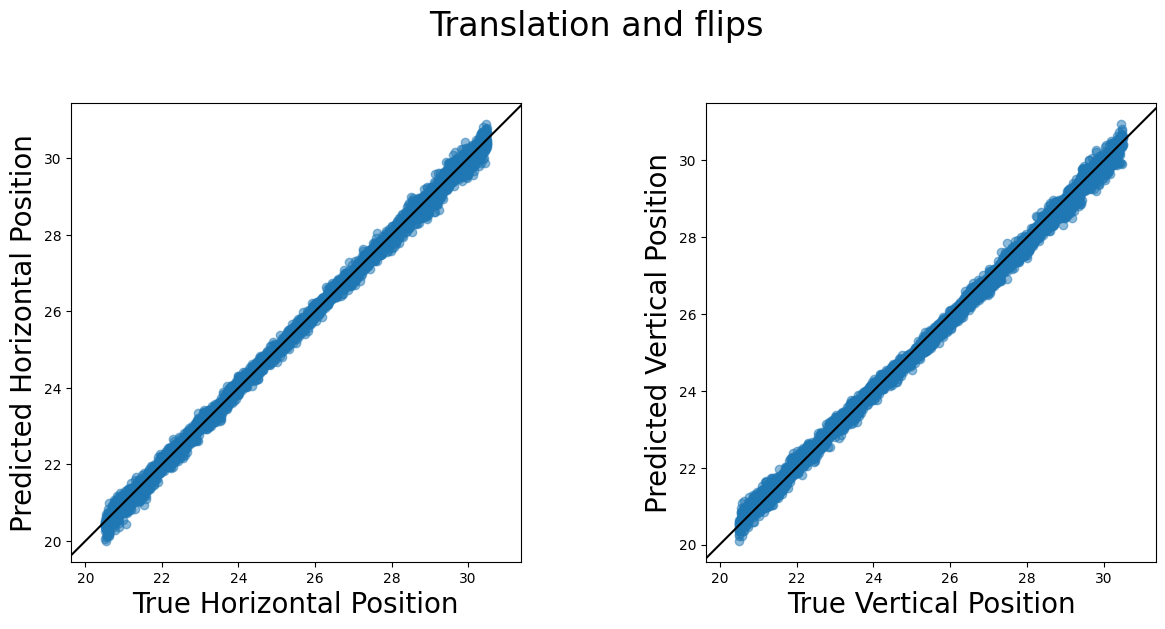

In [ ]:
#%% Plot with flips

predictions = (localizer_with_flips(images).detach().numpy() 
               + image_size / 2 - 0.5)
plot_position_comparison(positions, predictions, title="Translation and flips")

In [ ]:
#%% Learn from rotations

def rotation_transform(batch, rotation_angles):
    """Rotate the batch of images by degrees"""
    return rotate(batch, rotation_angles)

def inverse_rotation_transform(preds, rotation_angles):
    """Conditionally inverse flip transformation based on should flip."""
    radians = -rotation_angles * torch.pi / 180.0  # Invert the angle
    cos = torch.cos(radians)
    sin = torch.sin(radians)

    x, y = preds[:, 0], preds[:, 1]
    x_new = cos * x - sin * y
    y_new = sin * x + cos * y
    return torch.stack((x_new, y_new), dim=1)

class ParticleLocalizerWithRotations(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""

    def forward_transform(self, batch, translation, angles):
        """Apply forward translations and flips to the batch."""
        batch = image_translation(batch, translation)
        batch = rotation_transform(batch, angles)
        return batch

    def inverse_transform(self, preds, translation, angles):
        """Apply the inverse transformation to the predictions."""
        preds = inverse_rotation_transform(preds, angles)
        preds = inverse_translation(preds, translation)
        return preds

    def random_arguments(self):
        """Generate random arguments for translations and flips."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "angles": (rand(self.n_transforms).float().to(self.device) - 0.5)* 360}

In [ ]:
#%% Training with rotations

localizer_with_rotations = ParticleLocalizerWithRotations(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3),
).create()
trainer_with_flips = dl.Trainer(max_epochs=100)
trainer_with_flips.fit(localizer_with_rotations, dataloader)

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 97.2 K | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
97.2 K    Trainable params
0         Non-trainable params
97.2 K    Total params
0.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Para

Training: |          | 0/? [00:00<?, ?it/s]

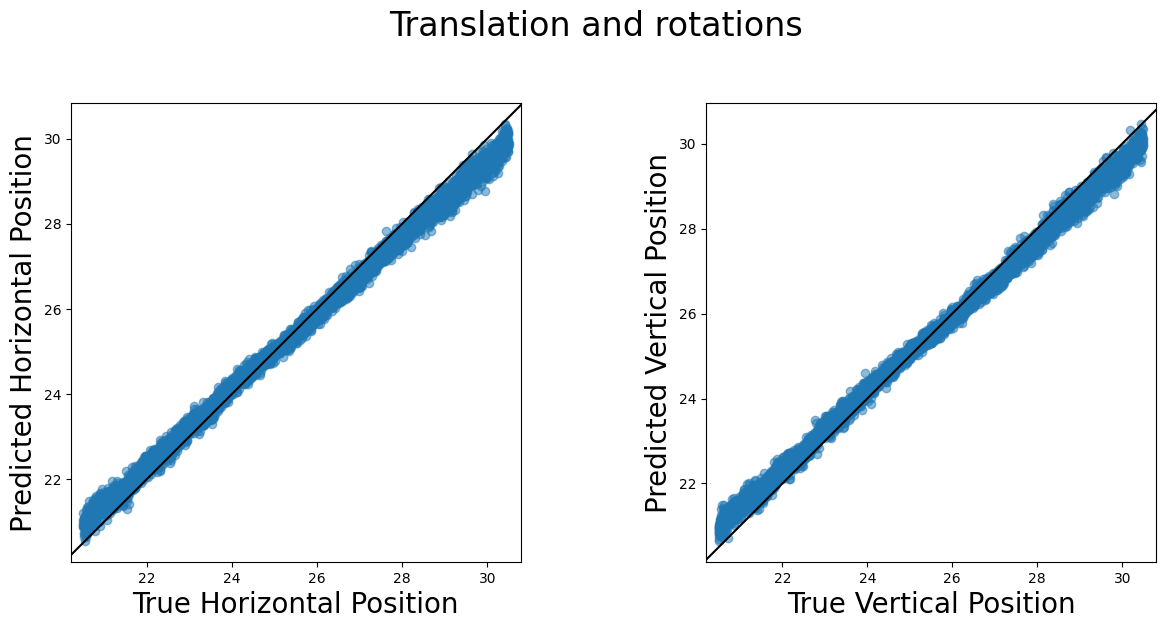

In [ ]:
#%% Plot with rotations

predictions = (localizer_with_rotations(images).detach().numpy() 
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions, title="Translation and rotations")

In [ ]:
#%% LodeSTAR improve

dataloader_lodestar = dl.DataLoader(train_dataset, batch_size=4, shuffle=True)

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()

trainer_lodestar = dl.Trainer(max_epochs=100)
trainer_lodestar.fit(lodestar, dataloader_lodestar)

INFO: 
  | Name          | Type                       | Params | Mode 
---------------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K  | train
1 | between_loss  | L1Loss                     | 0      | train
2 | within_loss   | L1Loss                     | 0      | train
3 | train_metrics | MetricCollection           | 0      | train
4 | val_metrics   | MetricCollection           | 0      | train
5 | test_metrics  | MetricCollection           | 0      | train
6 | optimizer     | Adam                       | 0      | train
---------------------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                       | Params | Mode 
------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

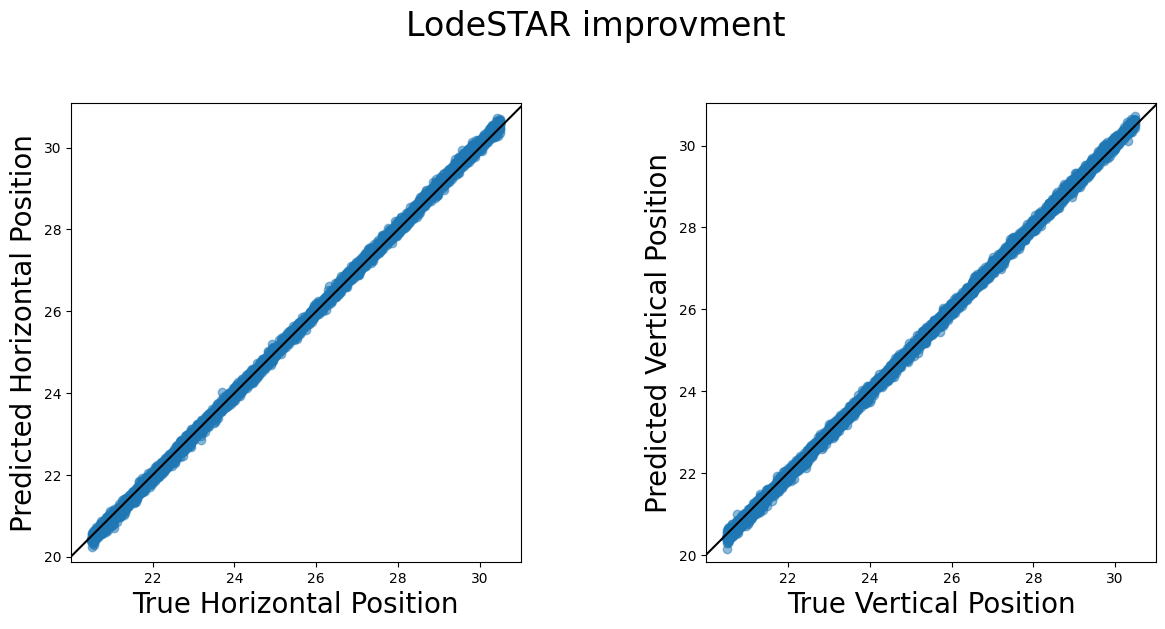

In [ ]:
#%% Plot LodeSTAR

lodestar_predictions = lodestar.pooled(images).detach().numpy()

plot_position_comparison(positions, lodestar_predictions, title = "LodeSTAR improvment")